In [22]:
import pickle as pkl
import psycopg2
import numpy as np
import pandas as pd
from pandas import ExcelWriter
import datetime
from dateutil.parser import parse
from datetime import timedelta
import random
import copy
import matplotlib.pyplot as plt
from pylab import *
from collections import Counter
import re

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [23]:
## Last Change here dooo thisssssssssssssssss -> np.sum check for len=0
def getProductionFunc(end_date, records, no_of_aspects):
    ret = [0]*no_of_aspects
    
    produced = records[ records[:,3] <= end_date ]
    total_produced = len(produced)
    
    allAspectsProduced = np.sum(produced[:,1])
    ret = [allAspectsProduced.count(i)/total_produced for i, x in enumerate(ret)]
    return np.array(ret)

In [24]:
def getShortProductionFunc(end_date, period, records, no_of_aspects):
    ret = [0]*no_of_aspects
    
    period = timedelta(days=period)
    startTime = end_date-period
    
    produced = records[ (records[:,3] >= startTime) & (records[:,3] <= end_date) ]
    total_produced = len(produced)
    
    if total_produced == 0:
        return np.array(ret)
    
    allAspectsProduced = np.sum(produced[:,1])
    ret = [allAspectsProduced.count(i)/total_produced for i, x in enumerate(ret)]
    return np.array(ret)

In [25]:
def getDesiredDist(no_of_aspects, anti_asp0 = None):
    if anti_asp0 is None:
        # Equal distribution case
        ret = np.array([1/no_of_aspects]*no_of_aspects)
    else:
        ret = np.array([anti_asp0, 1.0-anti_asp0])
    return ret

In [26]:
#achieved distribution is (number of articles with aspect i)/(number of total articles) - multilabel
def getAchievedDist(feed_list, feed_dates=None, time=None):
    ret = [0]*no_of_aspects
    
    #Filter articles based on date -- optional
    if(feed_dates is None):
        feed_list = np.vstack(feed_list)
    else:
        oldest_date = feed_dates[-1] - timedelta(days=time)
        list_of_indices = [idx for idx, val in enumerate(feed_dates) if val > oldest_date]
        feed_list = [feed_list[idx] for idx in list_of_indices]
    
    #Count each aspect
    total_list = np.vstack(feed_list)
    allAspectsProduced = np.sum(total_list[:,1])
    
    if allAspectsProduced == 0:
        return np.array(ret)
    
    #Sum total
    total_articles = len(total_list)
    
    ret = [allAspectsProduced.count(i)/total_articles for i, x in enumerate(ret)]
    return np.array(ret)

In [27]:
#achieved distribution is (number of articles with aspect i)/(sum of number of aspects in each article) - multilabel
def getAchievedRelDist(feed_list, feed_dates=None, time=None):
    ret = [0]*no_of_aspects
    
    #if len(feed_list) == 0 or len(feed_list[0]) == 0:
    #    return np.array(ret)
    
    #Filter articles based on feed-produce date -- optional
    if(feed_dates is None):
        feed_list = np.vstack(feed_list)
    else:
        oldest_date = feed_dates[-1] - timedelta(time=time)
        list_of_indices = [idx for idx, val in enumerate(feed_dates) if val > oldest_date]
        feed_list = [feed_list[idx] for idx in list_of_indices]
    
    #Count each aspect
    total_list = np.vstack(feed_list)
    allAspectsProduced = np.sum(total_list[:,1])
    
    # check if total list was empty, instead of returning a list ^ would then return 0.
    if allAspectsProduced == 0:
        return np.array(ret)
    
    #Sum total
    total_all_aspects = len(allAspectsProduced)
    
    ret = [allAspectsProduced.count(i)/total_all_aspects for i, x in enumerate(ret)]
    return np.array(ret)

### We use softmax because it is differentiable and not discrete. 
### Helps for just aspects, min-max normalisation would otherise just cast to 0 or 1.

In [28]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def fair_scores3(Dj, Aj):
    Wj = Dj - Aj
    if not Wj.any():
        return Dj
    return softmax(10*Wj)

def fair_scores2(Dj, Aj):
    Wj = Dj - Aj
    if not Wj.any():
        return Dj
    return (Wj - np.min(Wj))/(np.max(Wj) - np.min(Wj))

In [29]:
def runRandomFeed(records, no_of_aspects):
    ### Parameters
    T0 = datetime.date(2011, 7, 1)
    Tf = records[-1][3]
    feed_publication_freq = 1
    feed_size = 4
    ###
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    
    next_date = T0
    while next_date <= Tf:
        
        # Get articles before end date from last 15 days and sort reverse
        start_date = next_date - timedelta(days=15)
        published = records[ (records[:,3] >= start_date) & (records[:,3] <= next_date) ]
        published = published[published[:,3].argsort()[::-1]]
        
        # Feed Size = average no. of articles over last 15 days. ## Last change
        RTTm = len( published[published[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - 1/8)*RTTs + (1/8)*RTTm
            RTTd = (1 - 1/4)*RTTd + (1/4)*(RTTm-RTTs)
        feed_size = int(RTTs + 2*RTTd)
        feed_size = max(feed_size, 1)
        #print(RTTm," - ", RTTs," - ", RTTd, " => ", feed_size)
        #feed_size = max( 4, len(published)/15 )
        #feed_size = min(feed_size, 15)
        #feed_size = int(feed_size)
        
        #Get news feed randomly without replacement
        indexes = np.random.choice(len(published), size=min(feed_size, len(published)), replace=False)
        feed = published[indexes]
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Process last 15 for short term diversity, last 90 for long term fairness
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        
        # Get average age of an article
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))

        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [30]:
def runLatestFeed(records, no_of_aspects):
    ### Parameters
    T0 = datetime.date(2011, 7, 1)
    Tf = records[-1][3]
    feed_publication_freq = 1
    feed_size = 4
    ###
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    
    next_date = T0
    while next_date <= Tf:
        
        #Get articles before end date and sort reverse
        start_date = next_date - timedelta(days=15)
        published = records[ (records[:,3] >= start_date) & (records[:,3] <= next_date) ]
        published = published[published[:,3].argsort()[::-1]]
        
        # Feed Size = average no. of articles over last 15 days. ## Last change
        RTTm = len( published[published[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - 1/8)*RTTs + (1/8)*RTTm
            RTTd = (1 - 1/4)*RTTd + (1/4)*(RTTm-RTTs)
        feed_size = int(RTTs + 2*RTTd)
        feed_size = max(feed_size, 1)
        #feed_size = max( 4, len(published)/15 )
        #feed_size = min(feed_size, 15)
        #feed_size = int(feed_size)
        
        #Get news feed picking latest articles
        feed = published[0:feed_size]
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Process last 15 for short term diversity, last 30 for long term fairness
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        
        # Get average age of an article
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))
        
        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [31]:
def getMoreArticles(uj, k, feed_size, start_date, end_date, all_records, no_of_aspects):
    
    ## Comment the below 3 lines.
    last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
    last15 = last15[last15[:,3].argsort()[::-1]]
    return last15

    req_count = uj/(k*1.0)
    req_count = req_count*feed_size
    
    # Take articles in past 6 months, but not in last 15 days
    start_date2 = end_date - timedelta(days=180)
    last3m = all_records[ (all_records[:,3] >= start_date2) & (all_records[:,3] <= start_date) ]
    last3m = last3m[last3m[:,3].argsort()[::-1]]
    
    last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
    last15 = last15[last15[:,3].argsort()[::-1]]
    
    asps = np.sum(last15[:,1])
    cur_count = [0]*no_of_aspects
    if(asps != 0):
        cur_count = np.array([asps.count(i) for i, x in enumerate(cur_count)])
    else:
        cur_count = np.array(cur_count)
    
    for i in range(no_of_aspects):
        if cur_count[i] < req_count[i]:
            for ind, art in enumerate(last3m):
                if i in art[1]:
                    last15 = np.vstack([last15, art])
                    cur_count[art[1]] += 1
                    np.delete(last3m, (ind), axis=0)
                    ind -= 1
    return last15

In [32]:
def getDivScores(no_of_aspects, asps):
    occured=0
    b1l = np.array([0.0]*no_of_aspects)
    if asps == 0.0:
        return b1l
    for i in range(no_of_aspects):
        if i in asps:
            occured += 1
            b1l[i] = 1.0
    b1l = b1l/occured
    return b1l

In [55]:
# Here we use least over-exposed article approach
def getArticleList2(aspect_scores, all_records, feed_size, end_date, no_of_aspects, div_coeff, past_feed_list):
    ret_feed = np.empty( (0, all_records.shape[1]) )
        
    #2. Get aspects & aspect scores, normalise them
    aspects = np.array(range(no_of_aspects))
    
    if np.sum(aspect_scores) == 0:
        aspect_scores = np.array([1/no_of_aspects]*no_of_aspects)
    norm_aspect_scores = aspect_scores/np.sum(aspect_scores)
    
    #3. Set up local exposure constraint for diversity - Elisa Celis
    # Include a div_coeff ~~> represents diversity coefficient
    a1l = norm_aspect_scores
    
    #b1l => diversity scores. 
    # Distribute equally only amongst the ones where atleast an article occurs.
    start_date = end_date - timedelta(days=15)
    last15 = all_records[ (all_records[:,3] >= start_date) & (all_records[:,3] <= end_date) ]
    asps = np.sum(last15[:,1])
    b1l = getDivScores(no_of_aspects, asps)
    
    u1l = (1-div_coeff)*a1l + (div_coeff)*b1l
    print("--a1l-> ", a1l)
    #print("**b1l-> ", b1l)
    print("**u1l-> ", u1l)
    
    #1. Filter articles from last 15 days (rev. chrono.) - we consider only last 15 day articles
    published_new = getMoreArticles(u1l, 1.5, feed_size, start_date, end_date, all_records, no_of_aspects)

    #4. Initialise aspect exposures observed over last 14 days and filled counter
    asp_exposure = np.array([0]*no_of_aspects)
    if len(past_feed_list) != 0:
        past_feed_list = np.vstack(past_feed_list)
        for article in past_feed_list:
            asp_exposure[article[1]] += 1 
    filled = len(past_feed_list)
    
#     ###~~~ last change
#     filled=0
#     asp_exposure = np.array([0]*no_of_aspects)
    
    def pickLeastViolatingAspect(aspects, u1l, asp_exposure):
        np.random.shuffle(aspects)
        violation = asp_exposure - (filled+1)*u1l
        #print(violation)
        for a in violation.argsort():
            if a in aspects:
                return a
        
    #5. Start filling slots
    # Try that aspect which violates constraint the least
    # If can't find an article for it - update asp_exposure, u1l, aspects; continue;
    for slot in range(feed_size):
        
        # Exhausted constraints or not;
        found = False
        while not found:
            
            # If all violate constraint - let the feed be this much only
            if len(aspects) == 0:
                break
            each_aspect = pickLeastViolatingAspect(aspects, u1l, asp_exposure)
            
            for index, article in enumerate(published_new):
                print(article[1])
                if each_aspect in article[1]:
                    ret_feed = np.vstack([ret_feed, article])
                    published_new = np.delete(published_new, (index), axis=0)
                    index -= 1
                    filled += 1

                    # Update all aspect's exposures
                    asp_exposure[np.intersect1d(article[1], aspects)] += 1

                    found = True
                    break
            
            if not found:
                #print("Mayhem - ", each_aspect)
                # If that aspect does not exist in any recent articles - 
                # then delete that aspect - doesn't violate & not found
                aspects = np.delete(aspects, np.where(aspects == each_aspect))
                
                # Redistribute the rest feed among other aspects
                filled -= asp_exposure[each_aspect]
                u1l = u1l/u1l[aspects].sum()
    
    #print("Feed filled :=> ",len(ret_feed),"/",feed_size)
    return ret_feed

In [68]:
# With min threshold = 0.4
def runBasicHeur(records, Dj_first_comp, no_of_aspects, min_thr, div_coeff):
    ################ Parameters
    short_production_period = 15
    T0 = datetime.date(2011, 7, 1)
    Tf = records[-1][3]
    #Tf = records[40][3]
    feed_publication_freq = 1
    #feed_size = 4
    ################
    
    print("**********************")
    #print(Dj_first_comp)
    
    feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs = [], [], [], [], []
    rolling_window = 90
    
    next_date = T0
    while next_date <= Tf:
        if next_date == T0:
            Aj = np.array([1/no_of_aspects]*no_of_aspects)
        else:
            Aj = getAchievedDist(feed_list, feed_dates = feed_dates, time = rolling_window)
        
        #SPj = getShortProductionFunc(next_date, short_production_period, records, no_of_aspects)
        Dj = (min_thr)*np.array([1/no_of_aspects]*no_of_aspects) + (1-min_thr)*Dj_first_comp
        #print(str(Dj)+", " + str(min_thr)+"*"+str(Dj_first_comp)+", " + str(1-min_thr)+"*"+str(SPj))
        
        #Calculate aspect scores
        aspect_scores = fair_scores3(Dj , Aj)
        print("Dj -> ", str(Dj))
        print("Aj -> ", str(Aj))
        print("Nom-> ", str(aspect_scores))
              
        #1.a Feed Size = average no. of articles over last 15 days. ## Last change
        RTTm = len( records[records[:,3] == next_date] )
        if next_date == T0:
            RTTs = RTTm
            RTTd = RTTm/2
        else:
            RTTs = (1 - 1/8)*RTTs + (1/8)*RTTm
            RTTd = (1 - 1/4)*RTTd + (1/4)*(RTTm-RTTs)
        feed_size = int(RTTs + 2*RTTd)
        feed_size = max(feed_size, 1)
        
        #from IPython import embed; embed()
        
        #Get news feed
        feed = getArticleList2(aspect_scores, records, feed_size, next_date, no_of_aspects, div_coeff, feed_list[-14:])
        feed_list.append(feed)
        feed_dates.append(next_date)
        
        # Get Diversiy and Fairness scores
        feed_HHIs.append(getHHI(feed_list[-15:]))
        feed_GINIs.append(getGINI(feed_list[-90:], no_of_aspects))
        #print(feed_list[-15:][:,1])
        print(feed_HHIs[-1])
        
        # Get average age of an article
        if len(feed) == 0:
            feed_AGEs.append(0)
        else:
            ages = (next_date - feed[:,3])
            ages = ages / timedelta(days=1)
            feed_AGEs.append(np.mean(ages))
        
        #increment next date
        next_date = next_date + timedelta(feed_publication_freq)
        
    return feed_list, feed_dates, feed_HHIs, feed_GINIs, feed_AGEs

In [63]:
def getHHI(feeds):
    #feeds = np.array()
    feed = np.vstack(feeds)
    if len(feed) == 0:
        return 0 
    
    dist = getAchievedRelDist([feed])
    print(dist)
    score = np.sum(dist**2)
    return score

### Run Recommendation Code

In [64]:
# id, label, text, title, url, actualDate, date
articles = pkl.load(open("data.pkl", "rb"))
no_of_aspects = 2

In [ ]:
feed_list_hr0, feed_dates_hr0, feed_HHI_hr0, feed_GINI_hr0, feed_AGE_hr0 = runBasicHeur(articles, getDesiredDist(no_of_aspects, .0), no_of_aspects, 0.5, 0.8)
feed_list_hr1, feed_dates_hr1, feed_HHI_hr1, feed_GINI_hr1, feed_AGE_hr1 = runBasicHeur(articles, getDesiredDist(no_of_aspects, .2), no_of_aspects, 0.5, 0.8)
feed_list_hr2, feed_dates_hr2, feed_HHI_hr2, feed_GINI_hr2, feed_AGE_hr2 = runBasicHeur(articles, getDesiredDist(no_of_aspects, .4), no_of_aspects, 0.5, 0.8)
feed_list_hr3, feed_dates_hr3, feed_HHI_hr3, feed_GINI_hr3, feed_AGE_hr3 = runBasicHeur(articles, getDesiredDist(no_of_aspects, .6), no_of_aspects, 0.5, 0.8)
feed_list_hr4, feed_dates_hr4, feed_HHI_hr4, feed_GINI_hr4, feed_AGE_hr4 = runBasicHeur(articles, getDesiredDist(no_of_aspects, .8), no_of_aspects, 0.5, 0.8)
feed_list_hr5, feed_dates_hr5, feed_HHI_hr5, feed_GINI_hr5, feed_AGE_hr5 = runBasicHeur(articles, getDesiredDist(no_of_aspects, 1.), no_of_aspects, 0.5, 0.8)

In [467]:
getAchievedRelDist(feed_list_hr0)

array([0.40482574, 0.59517426])

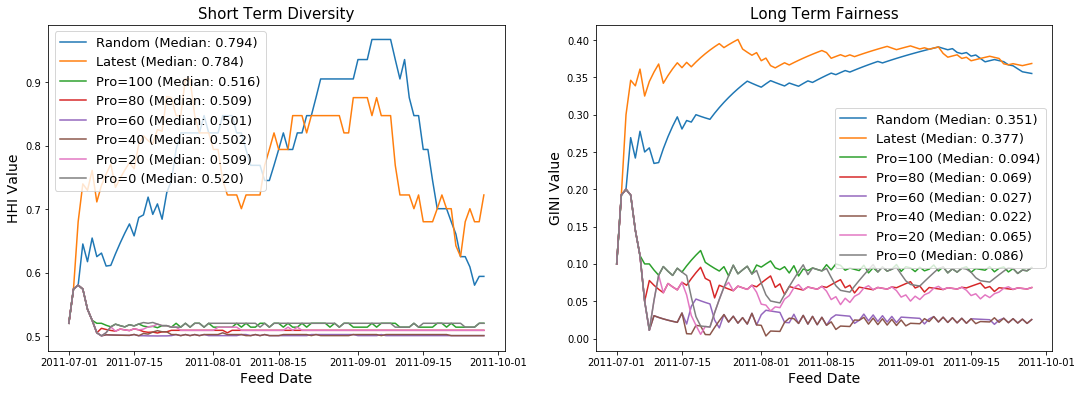

In [480]:
figs, axes = plt.subplots(1, 2, figsize=(18, 6))
#figs.suptitle('User Studies', size=20 )
plt.rc('legend',fontsize=13)

# Plot HHIs
axes[0].set_xlabel("Feed Date", size=14)
axes[0].set_ylabel("HHI Value", size=14)
axes[0].set_title("Short Term Diversity", size=15)
axes[0].plot(feed_dates_rnd, feed_HHI_rnd, label='Random (Median: %.3f)'%np.median(feed_HHI_rnd) )
axes[0].plot(feed_dates_fr, feed_HHI_fr, label='Latest (Median: %.3f)'%np.median(feed_HHI_fr) )

axes[0].plot(feed_dates_hr0, feed_HHI_hr0, label='Pro=100 (Median: %.3f)'%np.median(feed_HHI_hr0) )
axes[0].plot(feed_dates_hr1, feed_HHI_hr1, label='Pro=80 (Median: %.3f)'%np.median(feed_HHI_hr1) )
axes[0].plot(feed_dates_hr2, feed_HHI_hr2, label='Pro=60 (Median: %.3f)'%np.median(feed_HHI_hr2) )
axes[0].plot(feed_dates_hr3, feed_HHI_hr3, label='Pro=40 (Median: %.3f)'%np.median(feed_HHI_hr3) )
axes[0].plot(feed_dates_hr4, feed_HHI_hr4, label='Pro=20 (Median: %.3f)'%np.median(feed_HHI_hr4) )
axes[0].plot(feed_dates_hr5, feed_HHI_hr5, label='Pro=0 (Median: %.3f)'%np.median(feed_HHI_hr5) )
axes[0].legend()

# Plot GINIs
axes[1].set_xlabel("Feed Date", size=14)
axes[1].set_ylabel("GINI Value", size=14)
axes[1].set_title("Long Term Fairness", size=15)
axes[1].plot(feed_dates_rnd, feed_GINI_rnd, label='Random (Median: %.3f)'%np.median(feed_GINI_rnd) )
axes[1].plot(feed_dates_fr, feed_GINI_fr, label='Latest (Median: %.3f)'%np.median(feed_GINI_fr) )

axes[1].plot(feed_dates_hr0, feed_GINI_hr0, label='Pro=100 (Median: %.3f)'%np.median(feed_GINI_hr0) )
axes[1].plot(feed_dates_hr1, feed_GINI_hr1, label='Pro=80 (Median: %.3f)'%np.median(feed_GINI_hr1) )
axes[1].plot(feed_dates_hr2, feed_GINI_hr2, label='Pro=60 (Median: %.3f)'%np.median(feed_GINI_hr2) )
axes[1].plot(feed_dates_hr3, feed_GINI_hr3, label='Pro=40 (Median: %.3f)'%np.median(feed_GINI_hr3) )
axes[1].plot(feed_dates_hr4, feed_GINI_hr4, label='Pro=20 (Median: %.3f)'%np.median(feed_GINI_hr4) )
axes[1].plot(feed_dates_hr5, feed_GINI_hr5, label='Pro=0 (Median: %.3f)'%np.median(feed_GINI_hr5) )
axes[1].legend()

figs.savefig('us-gini-hhi.png')

### Output last 15 days of the total simulated 90 days feeds into nice excel or txt files to be consumed

In [469]:
def getSheets1(feed, dates, num):
    dfs = []
    for i in range(75, 90):
        df = pd.DataFrame(feed[i])
        df[2] = [x[0:3000] for x in df[2]]
        dfs.append( df )
    
    def save_xls(list_dfs, xls_path):
        with ExcelWriter(xls_path) as writer:
            for n, df in enumerate(list_dfs):
                df.to_excel(writer,'sheet%s' % n)
            writer.save()
    
    save_xls(dfs, str(num) + ".xls")

In [476]:
def getSheets2(feed, dates, num):
    file = open(str(num)+".txt", "w")
    dfs = []
    for i in range(75, 90):
        file.write("Feed Day: "+str(i-75) + "\n----------\n\n")
        df = pd.DataFrame(feed[i])
        for index, row in df.iterrows():
            sents = re.split(r'(?<=[.:;])\s', row[2])
            news = ' '.join([str(index+1) + ") "] + [row[4]+"." , "\n"] + sents[:3] + [" ....... "] + sents[-3:])
            file.write(news+"\n\n")
            
        #df[2] = [x[0:3000] for x in df[2]]
        #dfs.append( df )

In [477]:
getSheets2(feed_list_hr0, feed_dates_hr0, 0)
getSheets2(feed_list_hr1, feed_dates_hr1, 1)
getSheets2(feed_list_hr2, feed_dates_hr2, 2)
getSheets2(feed_list_hr3, feed_dates_hr3, 3)
getSheets2(feed_list_hr4, feed_dates_hr4, 4)
getSheets2(feed_list_hr5, feed_dates_hr5, 5)

In [309]:
df0

,0,1,2,3,4,5,6
0,394,[1],"New Delhi, July 5: The government will provide...",2011-09-28,Subsidies in bank account,https://www.telegraphindia.com/1110706/jsp/nat...,2011-07-06
1,392,[1],The Narendra Modi government kicked off on Fri...,2011-09-28,3 years of Modi govt: PM names India's longest...,http://www.hindustantimes.com/india-news/3-yea...,2017-05-26
2,382,[0],Targeting to cover the entire population by Ma...,2011-09-26,“Identifying gaps in Aadhaar enrolment”,http://www.thehindu.com/todays-paper/tp-nation...,2016-08-04
3,391,[1],"New Delhi, Apr 7, 2017 (PTI) 11:09 ISTTo avoid...",2011-09-28,Dhoni case: UIDAI sensitises agencies on celeb...,http://www.deccanherald.com/content/605129/dho...,2017-04-07
